In [1]:
import os, glob
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date, time, datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import np_utils
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,  accuracy_score
w_list= glob.glob("../result/merge_weather/*.csv")
p_list = glob.glob("../result/flower_price_byweek/*")
select_t = [(1,0),(3,2),(2,1),(2,3),(2,4)]
print(w_list)

Using TensorFlow backend.


['../result/merge_weather\\467480_嘉義.csv', '../result/merge_weather\\C0F9L0_后里.csv', '../result/merge_weather\\C0K490_古坑.csv', '../result/merge_weather\\C0X060_下營.csv']


In [4]:
class fp_pre:
    def __init__(self,fn_weather, fn_price):
        self.r_data = pd.read_csv(fn_weather, encoding="utf-8")
        self.lc_d = pd.read_csv("../lunar_done_new.csv", encoding="utf-8")
        self.df_pbw = pd.read_csv(fn_price, encoding="utf-8")
        self.d_data = self.r_data["Date"]
    
    
    def prep_rdata(self):
        r_data = self.r_data
        col_fix =  ['T.Max', 'T.Min', 'Precp','Temperature', 'RH', 'StnPres', 'WS', 'WSGust']
        for col in col_fix:
            old = r_data[col]
            new = []
            for i in range(len(old)):
                try:
                    new.append(float(old[i]))
                    tmp = float(old[i])
                except ValueError:
                    new.append(tmp)
            r_data[col] = new
        d_tmp = r_data['T.Max'] - r_data['T.Min']
        r_data["d_tmp"]= d_tmp
        drop_c =["Date",'T.Max', 'T.Min']
        r_data = r_data.drop(columns=drop_c)
        
        def to_zscore(df):
            col_x = df.columns.to_list()
            mean = df.mean(axis=0)
            std = df.std(axis=0)
            for i in range(len(col_x)):
                df[col_x[i]]=(df[col_x[i]]-mean[i])/std[i]
            return  df , (mean, std)
        r_data, self.recordz = to_zscore(r_data)
        self.r_data = r_data
        self.r_data_pre_done = r_data
    
    
    def join_lunar(self):
        self.r_data["Date"] = self.d_data
        self.r_data = self.r_data.join(self.lc_d.set_index("date"), on="Date")
        self.r_data = self.r_data.drop(columns="Date")
    
    
    def shift_rdata(self, shift1, shift2):
        dfs =[]
        arr_all =[]
        if shift2==0:
            df_s = self.r_data.copy()
        else:
            df_s = self.r_data.copy()
            df_s = df_s.shift(periods=shift2)
        arr_all = np.array(df_s)

        for i in range(1,shift1):
            tp = np.array(df_s.shift(periods=i))
            arr_all = np.concatenate((arr_all, tp), axis=1)
        df_all = pd.DataFrame(arr_all)
        df_all["date"] = self.d_data
        df_all = df_all.dropna()
        df_all = df_all.reset_index()
        df_all = df_all.drop(columns="index")
        self.d_data = df_all["date"]
        self.r_data = df_all
    
    
    def cutyw_rdata(self):
        def trans_to_y_w(d_date):
            year = int(d_date.split("-")[0])
            d_day = date(year,int(d_date.split("-")[1]), int(d_date.split("-")[2]))- date(year, 1, 1)
            d_w = 1+ (d_day.days // 7)
            if d_w ==53:
                d_w = 52
            result =  str(year) + "_" + str(d_w)

            if d_day.days % 7 ==6:
                return result
            else:
                return np.nan
        y_w = []
        for i in range(len(self.d_data)):
            y_w.append(trans_to_y_w(self.d_data[i]))
        self.r_data["y_w"] = y_w
        self.r_data = self.r_data.dropna()
        self.r_data = self.r_data.reset_index()
        self.r_data = self.r_data.drop(columns="index")
    
    
    def join_pbw_r_data(self):
#         df_join = self.df_pbw.join(self.r_data.set_index("y_w"), on="y_w")
        df_join = self.df_pbw.join(self.r_data.set_index("y_w"), on="y_w")
        df_join = df_join.dropna()
        df_join = df_join.reset_index()
        df_join = df_join.drop(columns="index")
        self.r_data = df_join
    
    
    def dummy_market(self,d_t_dummy):
        tmp_dum = pd.DataFrame()
        for col in d_t_dummy:
            tmp_dum[col] = self.r_data[col]
            dummy = pd.get_dummies(tmp_dum[col])
            self.r_data = pd.concat([self.r_data, dummy], axis=1)
        self.r_data = self.r_data.drop(columns=d_t_dummy)
        self.x = self.r_data
#         [,"year", "week","w_avg", "w_sale", "date", "y_w", "price_diff"]
    
    
    def drop_x_data(self,drop_c):
        self.x_beforedrop = self.x
        self.x = self.x.drop(columns=drop_c)
        self.input_units = self.x.shape[1]
        
    
    
    def all_prep(self, shift1, shift2,d_t_dummy):
        self.prep_rdata()
        self.join_lunar()
        self.shift_rdata(shift1, shift2)
        self.shift1 = shift1
        self.shift2 = shift2
        self.cutyw_rdata()
        self.join_pbw_r_data()
        self.dummy_market(d_t_dummy)
        self.extract_xy()
    
    def all_prep_nolunar(self, shift1, shift2,d_t_dummy):
        self.prep_rdata()
#         self.join_lunar()
        self.shift_rdata(shift1, shift2)
        self.shift1 = shift1
        self.shift2 = shift2
        self.cutyw_rdata()
        self.join_pbw_r_data()
        self.dummy_market(d_t_dummy)
        self.extract_xy()
    
    def extract_xy(self):
#     y_date = df_join["date"]
        self.y_yw = self.r_data["y_w"]
        self.y_raw = np.array(self.r_data["price_diff"])
        
    
    
    def y_to_class(self, list_y_class=[-0.1,0,0.1]):
        y_raw = self.y_raw
        self.y_list_class = list_y_class
        y_class = []
        for i in range(len(y_raw)):
            c = 0
            y = y_raw[i]
            for j in range(len(list_y_class)):
                if y > list_y_class[j]:
                    c = c +1
            y_class.append(c)
        self.y_class = np.array(y_class)
        self.y_freq = (np.bincount(y_class), list_y_class)
        self.output_class =len(np.bincount(y_class))
    
    
    def split_data(self, year):
        y_w = self.y_yw
        y_raw = self.y_raw
        y_year = []
        for  i in range(len(y_w)):
            y_year.append(int(y_w[i].split("_")[0]))
        y_year = np.array(y_year)
        self.split_info = np.unique(np.array(y_year), return_counts=True)
        b_train = y_year[:]<=year
        b_test = y_year[:]>year
        x = np.array(self.x)
        y = np.array(self.y_class)
        self.split_xy = (x[b_train,:], y[b_train] , x[b_test,:], y[b_test])
        self.split_xy_count = (x[b_train,:], y_raw[b_train] , x[b_test,:], y_raw[b_test])
    
    def model_build(self, dinp, epochs):
        x_train, y_train, x_test, y_test = self.split_xy
        model = Sequential()
        layer_0 = Dense(units =self.input_units//dinp, input_dim = self.input_units,
                        kernel_initializer = "random_normal", activation = "relu")
        model.add(layer_0)
        model.add(Dropout(0.25))
        layer_1 = Dense(units =self.input_units//(dinp*4),
                        kernel_initializer = "random_normal", activation = "relu")
        model.add(layer_1)
        model.add(Dropout(0.25))
#         layer_1 = Dense(units =(self.shift1+1),kernel_initializer = "random_normal", activation = "relu")
#         model.add(layer_1)
#         model.add(Dropout(0.25))
        layer_out = Dense(units = self.output_class,kernel_initializer = "random_normal", 
                          activation = "softmax")
        model.add(layer_out)
        #     model.summary()
        model.compile(loss="categorical_crossentropy",optimizer = "adam", metrics = ['accuracy'])
        self.train_model = model

    def model_test(self, epochs=10):
        x_train, y_train, x_test, y_test = self.split_xy
        x_train, x_train_d, y_train, y_train_d = train_test_split(x_train, y_train,  test_size=0.01, shuffle=True)
        train_history = self.train_model.fit(x = x_train, y = np_utils.to_categorical(y_train), validation_split = 0.1, epochs =epochs, verbose = 0)
        pre = self.train_model.predict_classes(x_test)
        acc = round(accuracy_score(y_test, pre)*100,2)
        return acc

In [ ]:
# w_list= glob.glob("../result/merge_weather/*.csv")
# p_list = glob.glob("../result/flower_price_byweek/*")
# select_t = [(1,0),(3,2),(2,1),(2,3),(2,4)]
# # 修改 select_t 可以拿不同測站 vs花花朵
# # st, flower = select_t[0]
# # fn_weather = w_list[st]
# # fn_price = p_list[flower]
# for st, flower in select_t:
#     fn_weather = w_list[st]
#     fn_price = p_list[flower]
#     print(fn_weather, fn_price)

#     # bullid class 讀取檔案
#     fp = fp_pre(fn_weather, fn_price)
#     # 花價格 + 天氣 + 節日後刪除資料
#     drop_c = ["year","w_avg", "w_sale", "date", "y_w", "price_diff"]
# #     drop_c = ["year", "w_sale", "date", "y_w"]
#     # 目前轉成 one-hot encoding 的資料
#     d_t_dummy = ["market", "week"]
#     # 設定數字 (總共要取幾天的資料,挑過幾天( 8 則跳兩週)
#     fp.all_prep(14,1,d_t_dummy)
#     fp.drop_x_data(drop_c)
#     # 設定結果 y pct_change 切分點 [-0.1 ,0, 0.1] 則切成 [-0.1以下, -0.1 ~ 0,0 ~ 0.1, 0.1 以上]
#     fp.y_to_class([0])
#     print(fp.y_freq)
#     print("if choice most, p = ",round(max(fp.y_freq[0])/sum(fp.y_freq[0])*100,2))
#     fp.split_data(2018)
#     epochs = 6
#     # for dinp in range(2,10):
#     #     print(dinp, end="\t")
#     dinp = 10
#     fp.model_build(dinp, epochs)
#     for run_times in range(5):
#     #         print(epochs, end="\t")
#         print(fp.model_test(epochs), end="\t")
#     print()

C0F9L0 Eustoma
58.52 52.59 56.296666666666674
58.52 49.63 53.95000000000001
58.52 49.63 54.403333333333336
59.26 49.63 54.69166666666666
65.93 49.63 56.29666666666667


,epochs,max_ACC,min_ACC,mean_ACC
0,6,58.52,52.59,56.296667
1,14,58.52,49.63,53.950000
2,22,58.52,49.63,54.403333
3,30,59.26,49.63,54.691667
4,38,65.93,49.63,56.296667


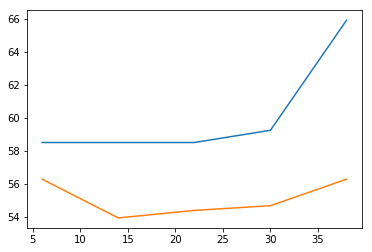

In [5]:
import matplotlib.pyplot as plt
w_list= glob.glob("../result/merge_weather/*.csv")
p_list = glob.glob("../result/flower_price_byweek/*")
select_t = [(0,0),(1,1),(1,2),(3,3),(3,4)]
# 修改 select_t 可以拿不同測站 vs花花朵
st, flower = select_t[2]
fn_weather = w_list[st]
fn_price = p_list[flower]
print(fn_weather.split("\\")[-1].split("_")[0], p_list[flower].split("\\")[-1].split("_")[0])
# fn_price = p_list[3]
weather_cf = []
# print(fn_price)
# for shift in range(11,18):
#     fn_weather =w_list[3]
#     print(fn_weather.split("\\")[-1].split("_")[0], fn_price.split("\\")[-1].split("_")[0])
    # bullid class 讀取檔案

fp = fp_pre(fn_weather, fn_price)
# 花價格 + 天氣 + 節日後刪除資料
drop_c = ["year","w_avg", "w_sale", "date", "y_w", "price_diff"]
#     drop_c = ["year", "w_sale", "date", "y_w"]
# 目前轉成 one-hot encoding 的資料
d_t_dummy = ["market", "week"]
# 設定數字 (總共要取幾天的資料,挑過幾天( 8 則跳兩週)
shift = 12
fp.all_prep(shift,15,d_t_dummy)
fp.drop_x_data(drop_c)
# 設定結果 y pct_change 切分點 [-0.1 ,0, 0.1] 則切成 [-0.1以下, -0.1 ~ 0,0 ~ 0.1, 0.1 以上]
fp.y_to_class([0])
#     print(fp.y_freq)
#     print("if choice most, p = ",round(max(fp.y_freq[0])/sum(fp.y_freq[0])*100,2))
fp.split_data(2018)
#     epochs = 2
# for dinp in range(2,10):
#     print(dinp, end="\t")
dinp = 10
acc = []
for epochs in range(6,40,8):
    fp.model_build(dinp, epochs)
#         print(epochs, end="\t")
    for i in range(3):
        acc.append(fp.model_test(epochs))
    print(max(acc), min(acc),np.array(acc).mean())
    weather_cf.append([epochs,max(acc), min(acc), np.array(acc).mean()])


df = pd.DataFrame(weather_cf, columns=["epochs", "max_ACC", "min_ACC", "mean_ACC"])
plt.plot(df["epochs"], df["max_ACC"])
plt.plot(df["epochs"], df["mean_ACC"])
# plt.plot(df["shift"])
pd.DataFrame(weather_cf, columns=["epochs", "max_ACC", "min_ACC", "mean_ACC"])

In [6]:
fp.train_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                10304     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 264       
_________________________________________________________________
dropout_10 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 18        
Total params: 10,586
Trainable params: 10,586
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 花名 測站名稱 shift (參數,預測週(1,8,15), 準確率範圍)
# Anthurium 467480     shift:(14,1,55~63%), (27,8,46~65%) (19,15,55~72%)
# Chrysanthemum C0F9L0 shift:(19,1,51~58%), (16,8,40~59%) (16,15,33~50%)
# Eustoma C0F9L0       shift:(3,1,67~73%) (16,8,49~57%) (12,15,51~63%)  epochs [10,]
# OrientalLily C0X060  shift:(17,1,77~79%) (22,8,66~75%) (14,15,43~64%) epochs [ , 12, ]
# Rose C0X060          shift:(7,1,47~64%) (18,8,42~64%) (18,15,55~69%)

In [ ]:
w_list= glob.glob("../result/merge_weather/*.csv")
p_list = glob.glob("../result/flower_price_byweek/*")
select_t = [(1,0),(3,2),(2,1),(2,3),(2,4)]
# 修改 select_t 可以拿不同測站 vs花花朵
# st, flower = select_t[0]
for st, flower in select_t:
    fn_weather = w_list[st].split("\\")[-1].split("_")[0], p_list[flower].split("\\")[-1].split("_")[0]
    fn_price = p_list[flower].split("\\")[-1].split("_")[0]
    print(fn_weather, fn_price)

In [ ]:
w_list= glob.glob("../result/merge_weather/*.csv")
p_list = glob.glob("../result/flower_price_byweek/*")
select_t = [(0,0),(1,1),(1,2),(3,3),(3,4)]
# 修改 select_t 可以拿不同測站 vs花花朵
st, flower = select_t[2]
fn_weather = w_list[st]
fn_price = p_list[flower]
print(fn_weather.split("\\")[-1].split("_")[0], p_list[flower].split("\\")[-1].split("_")[0])
weather_cf = []
fp = fp_pre(fn_weather, fn_price)
# 花價格 + 天氣 + 節日後刪除資料
drop_c = ["year","w_avg", "w_sale", "date", "y_w", "price_diff"]
d_t_dummy = ["market", "week"]
shift = 4
fp.all_prep(shift,15,d_t_dummy)
fp.drop_x_data(drop_c)
fp.y_to_class([0])
fp.split_data(2018)
x_train, y_train, x_test, y_test = fp.split_xy_count
x_train, x_train_ns= x_train[:,:shift*22], x_train[:,shift*22:]
x_test, x_test_ns = x_test[:,:shift*22], x_test[:,shift*22:]

x_train_rs = x_train.reshape(x_train.shape[0],shift, 22)
x_test_rs = x_test.reshape(x_test.shape[0],shift, 22)
# test = np.array(fp.x)
# print(test.shape)
# test, ns_x = test[:,:shift*22], test[:,shift*22:]
# res_x = test.reshape(test.shape[0],shift, 22)
# print(res_x.shape,ns_x.shape)




In [ ]:
# LSTM test
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
w_list= glob.glob("../result/merge_weather/*.csv")
p_list = glob.glob("../result/flower_price_byweek/*")
select_t = [(0,0),(1,1),(1,2),(3,3),(3,4)]
# 修改 select_t 可以拿不同測站 vs花花朵
st, flower = select_t[3]
fn_weather = w_list[st]
fn_price = p_list[flower]
print(fn_weather.split("\\")[-1].split("_")[0], p_list[flower].split("\\")[-1].split("_")[0])
weather_cf = []
fp = fp_pre(fn_weather, fn_price)
# 花價格 + 天氣 + 節日後刪除資料
drop_c = ["year","w_avg", "w_sale", "date", "y_w", "price_diff"]
d_t_dummy = ["market", "week"]
shift = 28
fp.all_prep(shift,1,d_t_dummy)
fp.drop_x_data(drop_c)
fp.y_to_class([-0.2,-0.1,0,0.1,0.2])
fp.split_data(2017)
x_train, y_train, x_test, y_test = fp.split_xy
x_train, x_train_ns= x_train[:,:shift*22], x_train[:,shift*22:]
x_test, x_test_ns = x_test[:,:shift*22], x_test[:,shift*22:]

x_train_rs = x_train.reshape(x_train.shape[0],shift, 22)
x_test_rs = x_test.reshape(x_test.shape[0],shift, 22)
# define dataset
X = x_train_rs
# reshape from [samples, timesteps] into [samples, timesteps, features]
y = y_train
# define model
model = Sequential()
layer_LSTM = LSTM(40, activation='relu', input_shape=(shift, 22))
# model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
model.add(layer_LSTM)
model.add(Dropout(0.25))
layer_0 = Dense(units =6, kernel_initializer = "random_normal", activation = "relu")
model.add(layer_0)
layer_out = Dense(units = fp.output_class,kernel_initializer = "random_normal",activation = "softmax")
model.add(layer_out)
model.summary()
model.compile(loss="categorical_crossentropy",optimizer = "adam", metrics = ['accuracy'])
# # fit model
train_history = model.fit(x = x_train_rs, y= np_utils.to_categorical(y_train), epochs=5, batch_size=1, verbose=0, validation_split = 0.2)
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title("Loss Graph")
plt.legend(['loss', 'val_loss'], loc="upper left")
pre = model.predict_classes(x_test_rs)
# pre = pre.reshape(pre.shape[0])
df = pd.DataFrame()
df["pre"] = pre
df["ans"] = y_test
# df.corr()
# plt.scatter(pre, y_test)
print(round(accuracy_score(y_test, pre)*100,2))


In [ ]:
pd.DataFrame(confusion_matrix(y_test,pre))

In [ ]:
# fp.x.shape


In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Conv1D, Dense, concatenate
# from keras.optimizers import Adagrad
# # fiting map:
# # x_s  > cov1D      >merge        
# #         x_ns
# # keras.layers.Conv1D(filters, kernel_size, strides=1, padding='valid', 
# #                     data_format='channels_last', dilation_rate=1, activation=None, 
# #                     use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
# #                     kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
# #                     kernel_constraint=None, bias_constraint=None)
# # keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', 
# #                    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
# #                    activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

# conv_filter = 10
# shift = 28
# model_shift = Sequential()
# layer_shift_input = Dense(1, input_shape=(shift, 22), activation='relu')
# model_shift.add(layer_shift_input)
# layer_Conv1D = Conv1D(conv_filter, kernel_size=(shift,),activation='relu')
# model_shift.add(layer_Conv1D)


# model_noshift = Sequential()
# layer_shift_ns_input = Dense(57, input_shape=(57,), activation='relu')
# model_noshift.add(layer_shift_ns_input)

# model_final = concatenate([model_shift, model_noshift])


# layer_0 = Dense(units =20, input_dim = conv_filter + 57,
#                 kernel_initializer = "random_normal", activation = "relu")
# model_final.add(layer_0)

# layer_out = Dense(units = fp.output_class,kernel_initializer = "random_normal",activation = "softmax")
# model_final.add(layer_out)
# model_final.compile(loss="categorical_crossentropy",optimizer = "adam", metrics = ['accuracy'])
# model_final.summary()

# # model_final.summary()


